<a href="https://colab.research.google.com/github/Suma-Marri/COP6526_Homework2/blob/main/COP6526_Homework2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 2

(1) Design a PySpark program to do logistic regression using "LogisticRegression" in "pyspark.ml.classification", with the dataset data_logistic_regression.csvDownload data_logistic_regression.csv. (7 points)

(2) Please draw a ROC curse using "matplotlib.pyplot". Its x-axis is "False Positive Rate", and y-axis is  "True Positive Rate". (3 points)

In [1]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

from google.colab import drive
drive.mount('/content/drive')

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Mounted at /content/drive


In [6]:
df = spark.read.csv("/content/drive/MyDrive/data_logistic_regression.csv", header = True, inferSchema = True)
df.show()

DataFrame[x1: double, x2: double, label: int]

In [7]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ('x1','x2'), outputCol= 'features')

assembler_df = assembler.transform(df)

In [8]:
train, test = df.randomSplit([0.7, 0.3], seed = 123)
print("Training Count: " + str(train.count()))
print("Test Count: " + str(test.count()))

Training Dataset Count: 55
Test Dataset Count: 25


In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train) 
# model1 = pipeline.fit(test)
predictions = model.transform(test)

In [10]:
predictions.show(5)

+-----------+-----------+-----+--------------------+--------------------+--------------------+----------+
|         x1|         x2|label|            features|       rawPrediction|         probability|prediction|
+-----------+-----------+-----+--------------------+--------------------+--------------------+----------+
|33.91550011|98.86943574|    0|[33.91550011,98.8...|[-2.8539067896537...|[0.05447972128038...|       1.0|
| 38.7858038|64.99568096|    0|[38.7858038,64.99...|[0.72216952806087...|[0.67308458291371...|       0.0|
|42.07545454|  78.844786|    0|[42.07545454,78.8...|[-1.0710455133625...|[0.25520430729188...|       1.0|
|47.26426911|  88.475865|    1|[47.26426911,88.4...|[-2.5000243606409...|[0.07585647226742...|       1.0|
|49.07256322|51.88321182|    0|[49.07256322,51.8...|[1.57961662297232...|[0.82915021558891...|       0.0|
+-----------+-----------+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9266666666666666


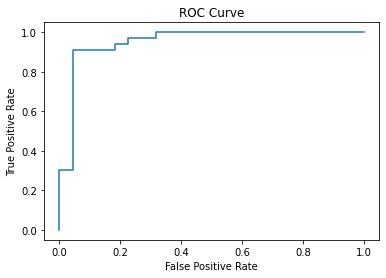

Area Under ROC: 0.9504132231404959


In [12]:
import matplotlib.pyplot as plt
predict = model.stages[-1].summary
roc = predict.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Area Under ROC: ' + str(predict.areaUnderROC))